# Data Exploration
The Data Cleansing notebook gave a cleaner version of our NYC Apartments data that we can now use to perform some data exploration. This notebook will explore relationships between predictors and the response (price), as well as between other predictors. This will aid us later when building our model to predict the price of an apartment.

Note: This data comes from an AWS Lambda Pipeline that can be seen in [this GitHub Repo](https://github.com/scochran3/LazyApartment/tree/master/data_pipeline/lambda_functions)

## Libraries

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import numpy as np
import warnings

# Set the stage
warnings.filterwarnings('ignore')
output_notebook()
plt.rcParams['figure.figsize'] = (12.0, 8.0)

Loading BokehJS ...

## Read in the data

In [203]:
df = pd.read_csv('housing_cleaned.csv', index_col='id').drop('Unnamed: 0', axis=1)
df.describe()

,area,bedrooms,bikeScore,distanceToNearestIntersection,has_image,has_map,price,repost_of,transitScore,walkScore,...,year,month,dow,day,hour,bedrooms_filled,advertises_no_fee,is_repost,sideOfStreetEncoded,postalCodeChopped
count,878.000000,3245.000000,3624.000000,3600.000000,3625.000000,3625.0,3625.000000,1.152000e+03,2379.000000,3624.000000,...,3625.0,3625.0,3625.000000,3625.000000,3625.000000,3507.000000,3625.00000,3625.000000,3625.000000,3625.000000
mean,938.219818,2.150693,75.759934,41.352545,0.893793,1.0,2664.065379,6.452617e+09,95.076923,89.160596,...,2019.0,6.0,4.965517,21.965517,12.248552,2.038494,0.16331,0.317793,0.502345,10591.190345
std,395.354928,0.950908,15.433162,61.738461,0.308145,0.0,965.455248,8.123898e+08,11.044998,16.716669,...,0.0,0.0,0.775360,0.775360,6.790605,1.033357,0.36970,0.465683,0.500063,1285.376970
min,225.000000,1.000000,6.000000,0.000000,0.000000,1.0,0.000000,1.884021e+09,28.000000,0.000000,...,2019.0,6.0,4.000000,21.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6401.000000
25%,717.000000,1.000000,65.000000,0.018989,1.000000,1.0,2060.000000,6.492153e+09,96.000000,90.000000,...,2019.0,6.0,4.000000,21.000000,6.000000,1.000000,0.00000,0.000000,0.000000,10458.000000
50%,850.000000,2.000000,80.000000,19.845731,1.000000,1.0,2587.000000,6.843346e+09,100.000000,95.000000,...,2019.0,6.0,5.000000,22.000000,14.000000,2.000000,0.00000,0.000000,1.000000,11211.000000
75%,1065.000000,3.000000,88.000000,66.076127,1.000000,1.0,3100.000000,6.895705e+09,100.000000,98.000000,...,2019.0,6.0,6.000000,23.000000,18.000000,3.000000,0.00000,1.000000,1.000000,11226.000000
max,3400.000000,6.000000,97.000000,769.854208,1.000000,1.0,5950.000000,6.917232e+09,100.000000,100.000000,...,2019.0,6.0,6.000000,23.000000,23.000000,6.000000,1.00000,1.000000,1.000000,18428.000000


## Assess the amount of NULL data points
This data is from from perfectly clean, we are scraping from Craigslist after all. The data pipeline is Craigslist Apartment Data -> Enrich with Mapquest Data -> Enrich with Walk Score data, so we tend to have a lot of missing data points. Let's quantify this.

In [204]:
# Create a DF with the count of nulls and the second column of percentage of df
nulls = pd.concat([df.isnull().sum(axis = 0), df.isnull().sum(axis = 0)/len(df)], axis=1)
nulls

,0,1
address,0,0.000000
area,2747,0.757793
bedrooms,380,0.104828
bikeScore,1,0.000276
datetime,0,0.000000
distanceToNearestIntersection,25,0.006897
has_image,0,0.000000
has_map,0,0.000000
name,0,0.000000
postalCode,0,0.000000


Because we have many null features in some features such as area we are unlikely to use these. However, we were able to make features from these features such as "includes_area" which states whether the post includes area. For now we will drop scores if they have over 10% missing values.

## Drop features with missing values

In [205]:
# threshold = .1
# df.dropna(thresh=(1-threshold)*len(df), axis=1, inplace=True)

## Correlations

In [206]:
# Shrunk DF with only features we will plot
df_shrunk = df[['bikeScore', 'distanceToNearestIntersection', 'has_image', 'sideOfStreetEncoded', 
                'walkScore', 'where', 'includes_area', 'dow', 'day', 'hour', 'bedrooms_filled',
               'advertises_no_fee', 'is_repost', 'postalCodeChopped', 'price']]
df_shrunk['bikeScore'].fillna(df_shrunk['bikeScore'].mean(), inplace=True)

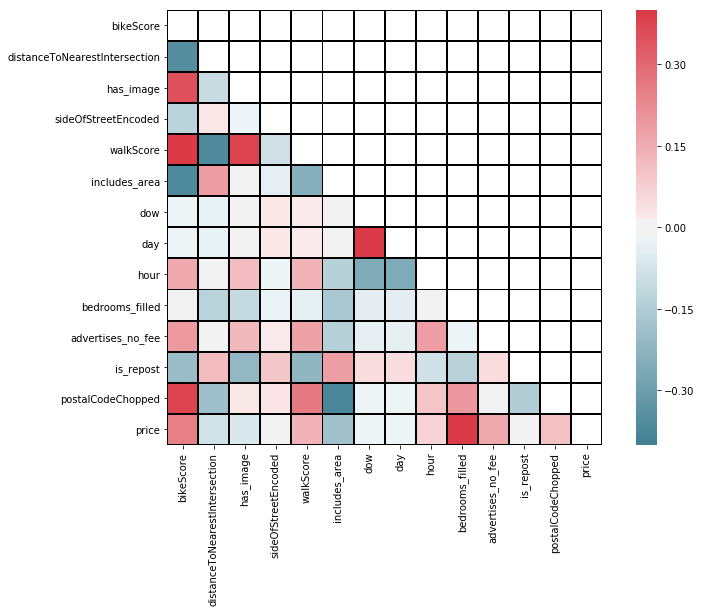

In [207]:
correlations = df_shrunk.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlations, mask=mask,
            cmap=cmap, linewidths=1, linecolor='#000000',
           square=True, vmax=.4, vmin=-.4)

## Univariate analysis

### Histogram of prices

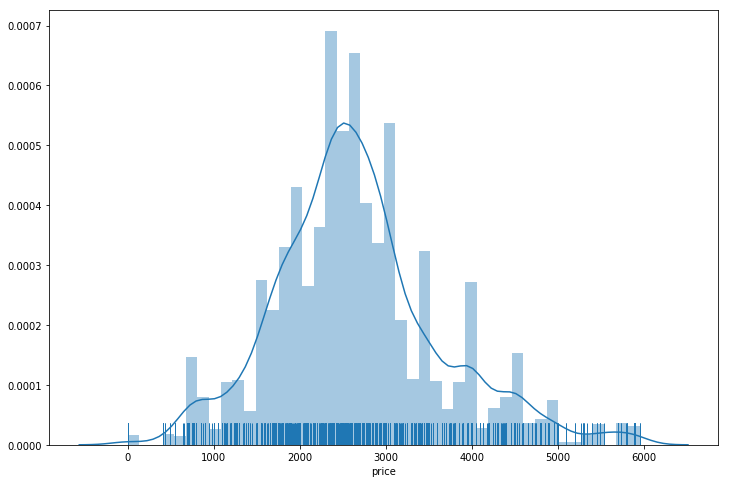

In [208]:
sns.distplot(df['price'], rug=True)

### Price by number of bedrooms

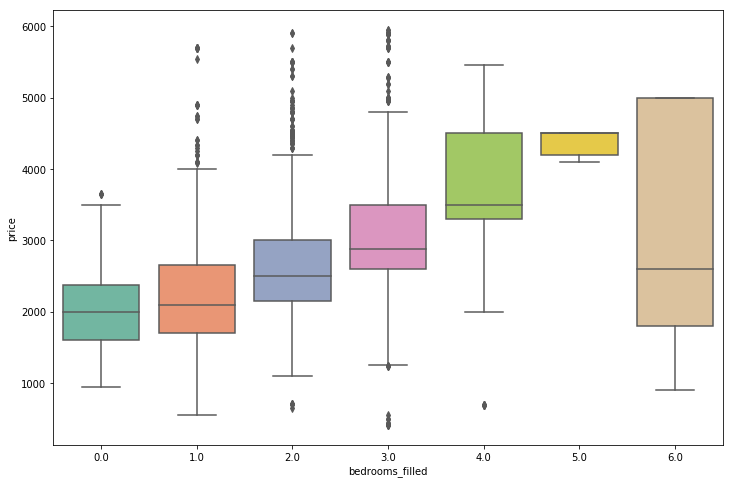

In [209]:
ax = sns.boxplot(x='bedrooms_filled', y='price', data=df, palette="Set2")

### Price by has_image

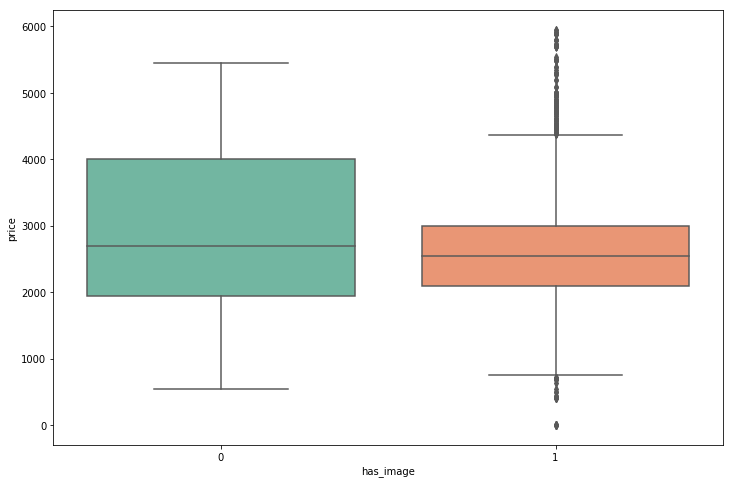

In [210]:
ax = sns.boxplot(x='has_image', y='price', data=df, palette="Set2")

### Price by neighborhood

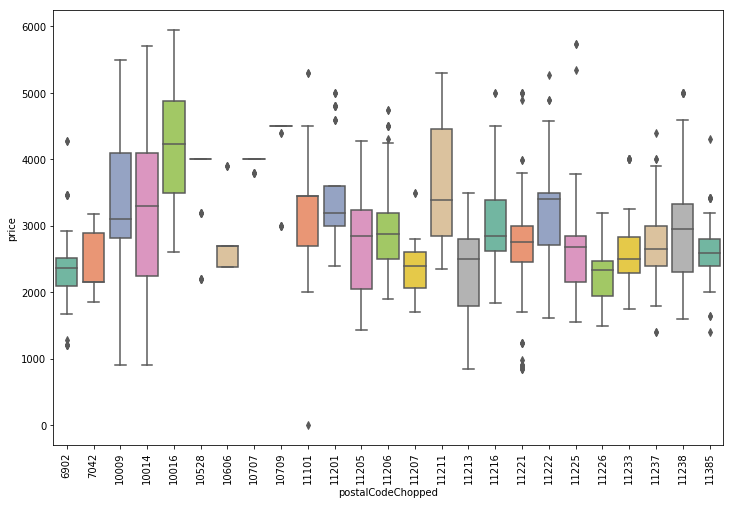

In [211]:
# Limit to top 25 neighborhoods by apartment count
df_top_25_hoods = df[df['postalCodeChopped'].isin(df['postalCodeChopped'].value_counts().head(25).index)]
df_top_25_hoods['postalCodeChopped'].value_counts()
plt.xticks(rotation=90)
ax = sns.boxplot(x='postalCodeChopped', y='price', data=df_top_25_hoods, palette="Set2")

### Price for whether or not they advertise "No Fee"

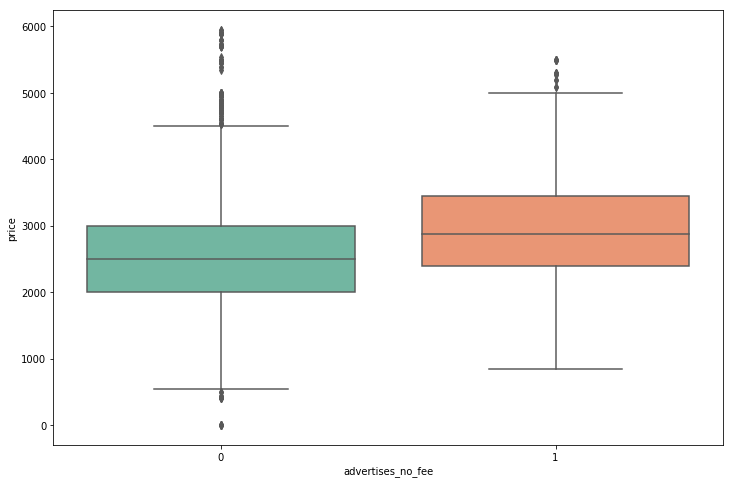

In [212]:
ax = sns.boxplot(x='advertises_no_fee', y='price', data=df, palette="Set2")

### Square Footage
I always read about how tiny New York City apartments are - let's see what the data tells us. Here we will overlay four different distributions - overall, 1 bedrooms, 2 bedrooms and 3 bedrooms.

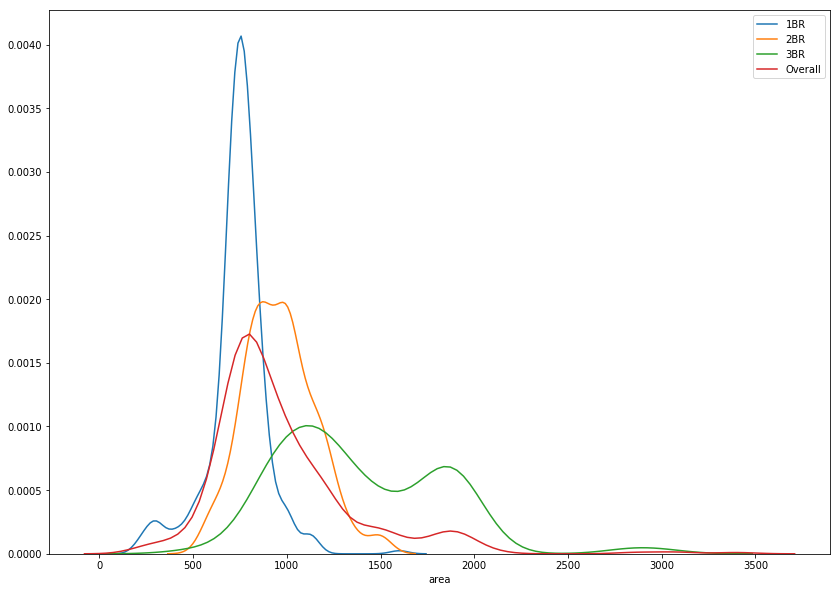

In [213]:
df_has_area = df.dropna(subset=['area', 'bedrooms'], axis=0)
fig, ax = plt.subplots(figsize=(14, 10))
sns.distplot(df_has_area[df_has_area['bedrooms']==1]['area'], label='1BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==2]['area'], label='2BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==3]['area'], label='3BR', hist=False)
sns.distplot(df_has_area['area'], label='Overall', hist=False)
ax.legend()

## Bivariate Analysis

### Area vs. Price
We have limited apartments that actually list the area but let's see how square footage increases with increasing the number of bedrooms

In [214]:
# Create string field for our color mapper
df_has_area['bedrooms_string'] = df_has_area['bedrooms'].astype(str) + " Bedrooms"
cmap = factor_cmap('bedrooms_string', palette=Spectral6, factors=df_has_area['bedrooms_string'].unique())

# Create figure
source = ColumnDataSource(df_has_area)
p = figure(sizing_mode='stretch_width', title="SQFT vs. Price", tools=[], toolbar_location=None)
p.scatter(x='area', y='price', source=source, legend='bedrooms_string',
          size=15, alpha=.6, fill_color=cmap, line_color='#000000', line_width=2)
p.legend.location = 'bottom_right'
p.xaxis.axis_label = "Square Feet"
p.yaxis.axis_label = "Price ($)"
p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

### Walk Score vs. Bike Score
Many algorithms will later not play nice with features that are perfectly correlated. While both features may be interesting to an individual it may be best to either only use one or a combination of the two in our model.

In [215]:
# Create figure
source = ColumnDataSource(df)
p = figure(sizing_mode='stretch_width', title="Walk Score vs. Bike Score", tools=[], toolbar_location=None)
p.scatter(x='walkScore', y='bikeScore', source=source)
p.xaxis.axis_label = "Walk Score (/100)"
p.yaxis.axis_label = "Bike Score (/100)"
# p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

## Price Over Time
Let's look at how prices vary over time for NYC Apartments

In [216]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df_price_per_day = df.set_index('datetime')[['price']]
df_price_per_day = df_price_per_day.resample('d').median().reset_index()

In [217]:
# Create the plot
source = ColumnDataSource(df_price_per_day)
p = figure(title="NYC Apartment Median Price Over Time", sizing_mode='stretch_width', x_axis_type='datetime')
p.line(x='datetime', y='price', line_width=2, color='#2e485c', source=source)
p.y_range = Range1d(0, df_price_per_day['price'].max()*1.05)
show(p)